### Data Collection and Cleaning
##### Youtube API , channel: freecodecamp

In [1]:
#credits: https://www.youtube.com/watch?v=D56_Cx36oGY
#google-api-python-client == 2.58

import os
from googleapiclient.discovery import build
import pandas as pd 
from dateutil import parser
import json
import plotly.express as px
from dotenv import load_dotenv
load_dotenv(".env")
API_KEY = os.getenv("API_KEY")

channel_ids = ['UC8butISFwT-Wl7EV0hUK0BQ']

api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(api_service_name, api_version, developerKey=API_KEY)
  

API resources used:
use the list method on below API resources:
Channel resource
PlaylistItems resource
videos resource

In [2]:
#channel resource contains information about a youtube channel
#use the list method to gather channel information by specifying the channel id 
def get_channel_stats(youtube, channel_ids):
    
    all_data = [] #initialize empty list
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'hiddensubscriber':item['statistics']['hiddenSubscriberCount'],
                'views': item['statistics']['viewCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return(pd.DataFrame(all_data))


In [3]:
channel_stats = get_channel_stats(youtube, channel_ids)
channel_stats

,channelName,subscribers,hiddensubscriber,views,playlistId
0,freeCodeCamp.org,6530000,False,445806913,UU8butISFwT-Wl7EV0hUK0BQ


In [7]:
channel_stats.subscribers = channel_stats.subscribers.astype(float)

In [10]:
subsold = pickle.load(open(my_path/'subsold.pkl','rb'))

In [9]:
from pathlib import Path
import pickle
root = Path(".")
my_path = root/'pickle files'

subsnew = channel_stats.copy()
with open(my_path/'subsnew.pkl','wb') as f:
        pickle.dump(subsnew,f)

diffsubs = subsnew.subscribers[0] - subsold.subscribers[0]

with open(my_path/'diffsubs.pkl','wb') as f:
        pickle.dump(diffsubs,f)

In [7]:
#use playlistItems().list() method returns a collection of playlist items that match the API request parameters
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [8]:
#next call the get_video_ids resource to visualize the resource representation for this channel
#use json.dumps() method to print out the response 
#print out response for first 5 videos

playlist_id = 'UU8butISFwT-Wl7EV0hUK0BQ'
video_ids = get_video_ids(youtube, playlist_id)
request = youtube.videos().list(part="snippet,contentDetails,statistics",
            id=video_ids[0:5]
        )
response = request.execute() 
print(json.dumps(response, indent=2, sort_keys=True))

{
  "etag": "rd6PuOVQxIOiz4sZ3ncHtCeucuM",
  "items": [
    {
      "contentDetails": {
        "caption": "false",
        "contentRating": {},
        "definition": "hd",
        "dimension": "2d",
        "duration": "PT5H1M49S",
        "licensedContent": true,
        "projection": "rectangular"
      },
      "etag": "7rhM7Io1EPuHnqdkIc6qo40jR70",
      "id": "F6P0hve2clE",
      "kind": "youtube#video",
      "snippet": {
        "categoryId": "27",
        "channelId": "UC8butISFwT-Wl7EV0hUK0BQ",
        "channelTitle": "freeCodeCamp.org",
        "defaultAudioLanguage": "en",
        "defaultLanguage": "en",
        "description": "Build a responsive cross-platform Google Docs Clone using Flutter & Node.js. This tutorial is designed for beginners in Node.js and no prior knowledge Javascript is required. This course will go through Google Authentication WITHOUT Firebase, keeping the users logged in, creating new documents, viewing the list of documents created by user, updating

From the resource representation we see that we can leverage necessary data from the snippet, statistics and contentDetails parts. Lets create a function (get_video_details) to call extract each key value pair from the response and save it into a dataframe.

youtube api referrence: https://developers.google.com/youtube/v3/docs/videos

In [9]:
def get_video_details(youtube, video_ids):

    all_video_info = [] # instantiate empty list
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {} #instantiate empty dictionary
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    #implement try try except block to retrieve all videos including those without tags
                    try:  
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info) #append results from video_info dict to all_video_info list
    
    return pd.DataFrame(all_video_info) #covert list to dataframe

In [10]:
#get channel details
def get_video_details(youtube, video_ids):

    all_video_info = [] # instantiate empty list
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {} #instantiate empty dictionary
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    #implement try try except block to retrieve all videos including those without tags
                    try:  
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info) #append results from video_info dict to all_video_info list
    
    return pd.DataFrame(all_video_info) #covert list to dataframe

In [11]:
#playlist id was determined by calling the playlistItems API request
playlist_id = "UU8butISFwT-Wl7EV0hUK0BQ"
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)
len(video_ids)

1366

In [12]:
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

playlist_id = 'UU8butISFwT-Wl7EV0hUK0BQ'
video_ids = get_video_ids(youtube, playlist_id)

def get_video_details(youtube, video_ids):

    all_video_info = [] # instantiate empty list
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {} #instantiate empty dictionary
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    #implement try try except block to retrieve all videos including those without tags
                    try:  
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info) #append results from video_info dict to all_video_info list
    
    return pd.DataFrame(all_video_info) #covert list to dataframe

video_df = get_video_details(youtube, video_ids)

In [11]:
dfcurr = video_df.copy()

In [ ]:
dfcurr = pickle.load(open(my_path/'dfcurr.pkl','rb'))

dfcurr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        1350 non-null   object
 1   channelTitle    1350 non-null   object
 2   title           1350 non-null   object
 3   description     1350 non-null   object
 4   tags            968 non-null    object
 5   publishedAt     1350 non-null   object
 6   viewCount       1350 non-null   object
 7   likeCount       1327 non-null   object
 8   favouriteCount  0 non-null      object
 9   commentCount    1350 non-null   object
 10  duration        1350 non-null   object
 11  definition      1350 non-null   object
 12  caption         1350 non-null   object
dtypes: object(13)
memory usage: 137.2+ KB


In [ ]:
#track real-time change in dataframe and append 
from pathlib import Path
import pickle

root = Path(".")
my_path = root/'pickle files'

dfcurr = video_df2.copy()
dfold = pickle.load(open(my_path/'video_df.pkl','rb'))
#dfold = dfold.iloc[2:,:]
#dfcurr = dfcurr.iloc[1:,:]
with open(my_path/'video_df.pkl','wb') as f:
    pickle.dump(dfold,f)

dfold = pickle.load(open(my_path/'video_df.pkl','rb'))
diff = dfcurr.shape[0] - dfold.shape[0]


#pickle current data
with open(my_path/'dfcurr.pkl','wb') as f:
    pickle.dump(dfcurr,f)

#pickle video_df2 with new dataframe

with open(my_path/'video_df2.pkl','wb') as f:
    pickle.dump(video_df2,f)

with open(my_path/'video_df.pkl','wb') as f:
    pickle.dump(video_df,f)


#whatever is the number of new videos uploaded that is tracked. 
if dfold.shape[0] != dfcurr.shape[0]:
    with open(my_path/'dfdiff.pkl','wb') as f:
        pickle.dump(diff,f)




In [ ]:
video_df.shape[0]

NameError: name 'video_df' is not defined

In [ ]:
diff

0

In [ ]:
diff = pickle.load(open(my_path/'dfdiff.pkl','rb'))

In [ ]:
diff

3

In [ ]:
with open(my_path/'video_df.pkl','wb') as f:
    pickle.dump(video_df,f)

In [ ]:
video_df123 = pickle.load(open(my_path/'video_df.pkl','rb'))

In [ ]:
import pickle
from pathlib import Path
root = Path(".")
my_path = root/'pickle files'

video_new = pickle.load(open(my_path/'video_df.pkl','rb'))

In [ ]:
video_df.viewCount.sum() - video_df.viewCount[1:].sum()

7827.0

In [ ]:
df

,video_id,channelTitle_x,title_x,description_x,tags_x,publishedAt_x,viewCount_x,likeCount_x,favouriteCount_x,commentCount_x,...,viewCount_y,likeCount_y,favouriteCount_y,commentCount_y,duration_y,definition_y,caption_y,clean_description_y,clean_title_y,url_y
0,XBTJDpT2XaI,freeCodeCamp.org,React Coding Interview Prep – 30 Questions and...,Prepare for a React interview or improve your ...,None,2022-09-12T15:55:09Z,21237.0,1249.0,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3qBXWUpoPHo,freeCodeCamp.org,Angular for Beginners Course [Full Front End T...,Learn Angular in this complete course for begi...,None,2022-09-07T13:15:25Z,80822.0,3041.0,NaN,348.0,...,80822.0,3041.0,NaN,348.0,PT17H33M53S,hd,false,learn angular complete course beginner first l...,angular beginner course full front end tutoria...,https://www.youtube.com/watch?v=3qBXWUpoPHo
2,u6gSSpfsoOQ,freeCodeCamp.org,React JavaScript Framework for Beginners – Pro...,Learn React in this full course for beginners....,None,2022-08-31T14:16:33Z,153129.0,6399.0,NaN,442.0,...,153129.0,6399.0,NaN,442.0,PT8H26M3S,hd,false,learn react full course beginner react one pop...,react javascript framework beginner course,https://www.youtube.com/watch?v=u6gSSpfsoOQ
3,OXGznpKZ_sA,freeCodeCamp.org,CSS Tutorial – Full Course for Beginners,"In this in-depth course, you will learn about ...",None,2022-08-30T13:55:14Z,93254.0,4059.0,NaN,225.0,...,93254.0,4059.0,NaN,225.0,PT11H8M10S,hd,false,course learn key feature cs comprehensive cs c...,cs tutorial full course beginner,https://www.youtube.com/watch?v=OXGznpKZ_sA
4,pdy3nh1tn6I,freeCodeCamp.org,20 Beginner Python Projects,Improve your Python skills by learning how to ...,None,2022-08-29T12:41:22Z,108575.0,5035.0,NaN,244.0,...,108575.0,5035.0,NaN,244.0,PT3H11M7S,hd,false,improve python skill learn code beginner pytho...,beginner python project,https://www.youtube.com/watch?v=pdy3nh1tn6I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,_uWzpyr_5qk,freeCodeCamp.org,Computer Basics 5: How To Measure Data Size,http://FreeCodeCamp.com is a community of busy...,"[Free Code Camp, JavaScript, Pair Programming,...",2015-07-17T08:31:23Z,42487.0,NaN,NaN,27.0,...,42487.0,NaN,NaN,27.0,PT2M24S,hd,false,http community busy people learn code practice...,computer basic measure data size,https://www.youtube.com/watch?v=_uWzpyr_5qk
1343,xXLj5MbrI44,freeCodeCamp.org,Computer Basics 4: Decoding a Binary Number,http://FreeCodeCamp.com is a community of busy...,"[Free Code Camp, JavaScript, Pair Programming,...",2015-07-17T08:31:20Z,54420.0,NaN,NaN,27.0,...,54420.0,NaN,NaN,27.0,PT1M42S,hd,true,http community busy people learn code practice...,computer basic decode binary number,https://www.youtube.com/watch?v=xXLj5MbrI44
1344,veugT7A9psY,freeCodeCamp.org,Computer Basics 3: Intro to Binary Code,http://FreeCodeCamp.com is a community of busy...,"[Free Code Camp, JavaScript, Pair Programming,...",2015-07-17T08:31:17Z,47801.0,NaN,NaN,8.0,...,47801.0,NaN,NaN,8.0,PT1M,hd,true,http community busy people learn code practice...,computer basic intro binary code,https://www.youtube.com/watch?v=veugT7A9psY
1345,xj9mFD71Vfc,freeCodeCamp.org,Computer Basics 2: More Computer Hardware,http://FreeCodeCamp.com is a community of busy...,"[Free Code Camp, JavaScript, Pair Programming,...",2015-07-17T08:31:14Z,54147.0,NaN,NaN,12.0,...,54147.0,NaN,NaN,12.0,PT1M12S,hd,true,http community busy people learn code practice...,computer basic computer hardware,https://www.youtube.com/watch?v=xj9mFD71Vfc


In [ ]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,url,clean_description,clean_title
0,F6P0hve2clE,freeCodeCamp.org,Flutter Course – Build Full Stack Google Docs ...,Build a responsive cross-platform Google Docs ...,None,2022-10-20T14:13:28Z,54368.0,2188.0,NaN,62.0,PT5H1M49S,hd,false,https://www.youtube.com/watch?v=F6P0hve2clE,build responsive google doc clone use flutter ...,flutter course build full stack google doc clone
1,8mAITcNt710,freeCodeCamp.org,Harvard CS50 – Full Computer Science Universit...,Learn the basics of computer science from Harv...,None,2022-10-19T13:53:35Z,313928.0,21173.0,NaN,641.0,P1DT51M37S,hd,false,https://www.youtube.com/watch?v=8mAITcNt710,learn basic computer science harvard universit...,harvard full computer science university course
2,UGBJHYpHPvA,freeCodeCamp.org,Learn Svelte – Full Course for Beginners,Learn Svelte in this full course for beginners...,None,2022-10-17T15:14:42Z,41489.0,1366.0,NaN,97.0,PT23H9M34S,hd,false,https://www.youtube.com/watch?v=UGBJHYpHPvA,learn svelte full course beginner svelte javas...,learn svelte full course beginner
3,_uSrE-gIdFc,freeCodeCamp.org,3 ways to build a Flight Widget! (JavaScript +...,Learn how to build an airport flight status wi...,None,2022-10-13T13:40:12Z,60212.0,1560.0,NaN,84.0,PT2H18M51S,hd,false,https://www.youtube.com/watch?v=_uSrE-gIdFc,learn build airport flight status widget diffe...,way build flight widget javascript rest api da...
4,kTp5xUtcalw,freeCodeCamp.org,Docker Containers and Kubernetes Fundamentals ...,Learn how to use Docker and Kubernetes in this...,None,2022-10-12T12:48:48Z,79281.0,3353.0,NaN,69.0,PT5H56M37S,hd,false,https://www.youtube.com/watch?v=kTp5xUtcalw,learn use docker kubernetes complete course be...,docker container kubernetes fundamental full c...


In [ ]:
video_df['key1']=video_df['clean_title'].str.split().str[0]
video_df['key2']=video_df['clean_title'].str.split().str[1]
video_df['key3']=video_df['clean_title'].str.split().str[2]

In [ ]:
pd.set_option('display.max_rows', 2000)

In [ ]:
video_df.key1.value_counts()

react         128
build          61
learn          52
create         30
javascript     29
             ... 
super           1
legend          1
angry           1
pokémon         1
basejump        1
Name: key1, Length: 491, dtype: int64

In [ ]:
video_df.loc[(video_df[['key1','key2','key3']].isin(['certification','associate','practitioner'])).any(axis=1)]

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,url,clean_description,clean_title,key1,key2,key3
26,jZx8PMQjobk,freeCodeCamp.org,Azure Developer Associate (AZ-204) — Full Cour...,Prepare for the Microsoft Azure Developer Asso...,None,2022-08-22T14:46:40Z,96539.0,2625.0,NaN,90.0,PT13H29M45S,hd,false,https://www.youtube.com/watch?v=jZx8PMQjobk,prepare microsoft azure developer associate ce...,azure developer associate full course pass exam,azure,developer,associate
62,jpno8FSqpc8,freeCodeCamp.org,Google Cloud Associate Cloud Engineer Course -...,Prepare for the Google Cloud Associate Cloud E...,None,2022-05-02T13:31:32Z,395051.0,8777.0,NaN,233.0,PT20H2M40S,hd,false,https://www.youtube.com/watch?v=jpno8FSqpc8,prepare google cloud associate cloud engineer ...,google cloud associate cloud engineer course p...,google,cloud,associate
159,V4waklkBC38,freeCodeCamp.org,HashiCorp Terraform Associate Certification Co...,Prepare for the HashiCorp Terraform Associate ...,None,2021-10-05T14:04:49Z,442465.0,8410.0,NaN,347.0,PT13H10M4S,hd,false,https://www.youtube.com/watch?v=V4waklkBC38,prepare hashicorp terraform associate certific...,hashicorp terraform associate certification co...,hashicorp,terraform,associate
202,M1_v5HBVHWo,freeCodeCamp.org,CISSP Certification Course – PASS the Certifie...,CISSP is one of the most valuable Cyber Securi...,None,2021-07-06T13:00:08Z,549348.0,16287.0,NaN,383.0,PT13H21M32S,hd,false,https://www.youtube.com/watch?v=M1_v5HBVHWo,cissp one valuable cyber security certificate ...,cissp certification course pass certified info...,cissp,certification,course
231,10PbGbTUSAg,freeCodeCamp.org,Azure Administrator Certification (AZ-104) - F...,The Azure Administrator is the most popular Az...,None,2021-05-03T15:31:37Z,972833.0,17654.0,NaN,625.0,PT11H16M26S,hd,false,https://www.youtube.com/watch?v=10PbGbTUSAg,azure administrator popular azure certificatio...,azure administrator certification full course ...,azure,administrator,certification
418,si9tjcnxruU,freeCodeCamp.org,The Oracle Foundations Associate Cloud Certifi...,The Oracle Cloud Infrastructure Foundations Ce...,None,2020-05-02T11:06:18Z,208445.0,3871.0,NaN,315.0,PT2H47M6S,hd,false,https://www.youtube.com/watch?v=si9tjcnxruU,oracle cloud infrastructure foundation certifi...,oracle foundation associate cloud certificatio...,oracle,foundation,associate


In [ ]:
#make clickable url 

#def make_clickable(val):
#    return '<a target="_blank" href="{}">{}</a>'.format(val,val)

#video_df.style.format({'url':make_clickable})
keyword= video_df[['title','url','key1','key2','key3']]

In [ ]:
from pathlib import Path
import pickle

root = Path(".")
my_path = root/'pickle files'

with open(my_path/'keyword.pkl', 'wb') as f:
    pickle.dump(keyword,f)





In [ ]:
video_df.loc[video_df.clean_title.isin(['certificate'])]

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,url,clean_description,clean_title,key1,key2,key3


In [13]:
#generate urls for each record
video_df['url'] = 'https://www.youtube.com/watch?v='+video_df.video_id

In [14]:
#change datatype for numeric columns
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [14]:
video_df.shape

(1366, 14)

### Exploratory Data Analysis

In [15]:
#Topic Modeling, Text pre-processing
#lemmatization

#nltk packages
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.corpus import stopwords
nltk.download('stopwords')
import string

from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dsald\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dsald\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dsald\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dsald\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
#clean the data
VERB_CODES = {'VB','VBD','VBG','VBN','VBP','VBZ'}
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    temp = [] #initialize dictionary
    words = nltk.word_tokenize(text)
    tags = nltk.pos_tag(words)
    for i, word in enumerate(words):
        if tags[i][1] in VERB_CODES:
            lemmatized = lemma.lemmatize(word,'v')
        else:
            lemmatized = lemma.lemmatize(word)
        if lemmatized not in stop_words and lemmatized.isalpha():
            temp.append(lemmatized)
    final = ' '.join(temp)
    return final

video_df['clean_description'] = video_df['description'].apply(preprocess_text)

video_df['clean_title'] = video_df['title'].apply(preprocess_text)

In [66]:
#most viewed certification  courses
cloud = video_df.loc[(video_df[['key1','key2','key3']].isin(['aws','certification','associate','practitioner','azure','google'])).any(axis=1)]
c = cloud.sort_values(by='viewCount',ascending=False).head(10)
fig = px.bar(c, x='video_id',y='viewCount', color='title', text_auto='.2s')
fig.update_traces(textposition="outside")
fig.show()

In [64]:
# top 10 most viewed videos
#top10 = video_df.groupby('title').agg({'viewCount':['max']}).reset_index()
top10 = video_df[['title','video_id','viewCount']]
top10 = top10.sort_values(by='viewCount',ascending=False).head(10)
fig = px.bar(top10, x='video_id',y='viewCount', color='title', text_auto='.2s')
fig.update_traces(textposition="outside")
fig.show()

In [96]:
#top20 most liked videos
liked10 = video_df[['title','video_id','likeCount']]
liked10 = liked10.sort_values(by='likeCount',ascending=False).head(10)
liked10.rename(columns={'tile':'Title'})
fig = px.bar(liked10, x='video_id',y='likeCount', color='title')
fig.show()


In [79]:
#top 20 videos with most comments

comment20 = video_df[['title','video_id','commentCount']]
comment20 = comment20.sort_values(by='commentCount',ascending=False).head(20)
fig = px.bar(comment20, x='video_id',y='commentCount', color='title')
fig.show()

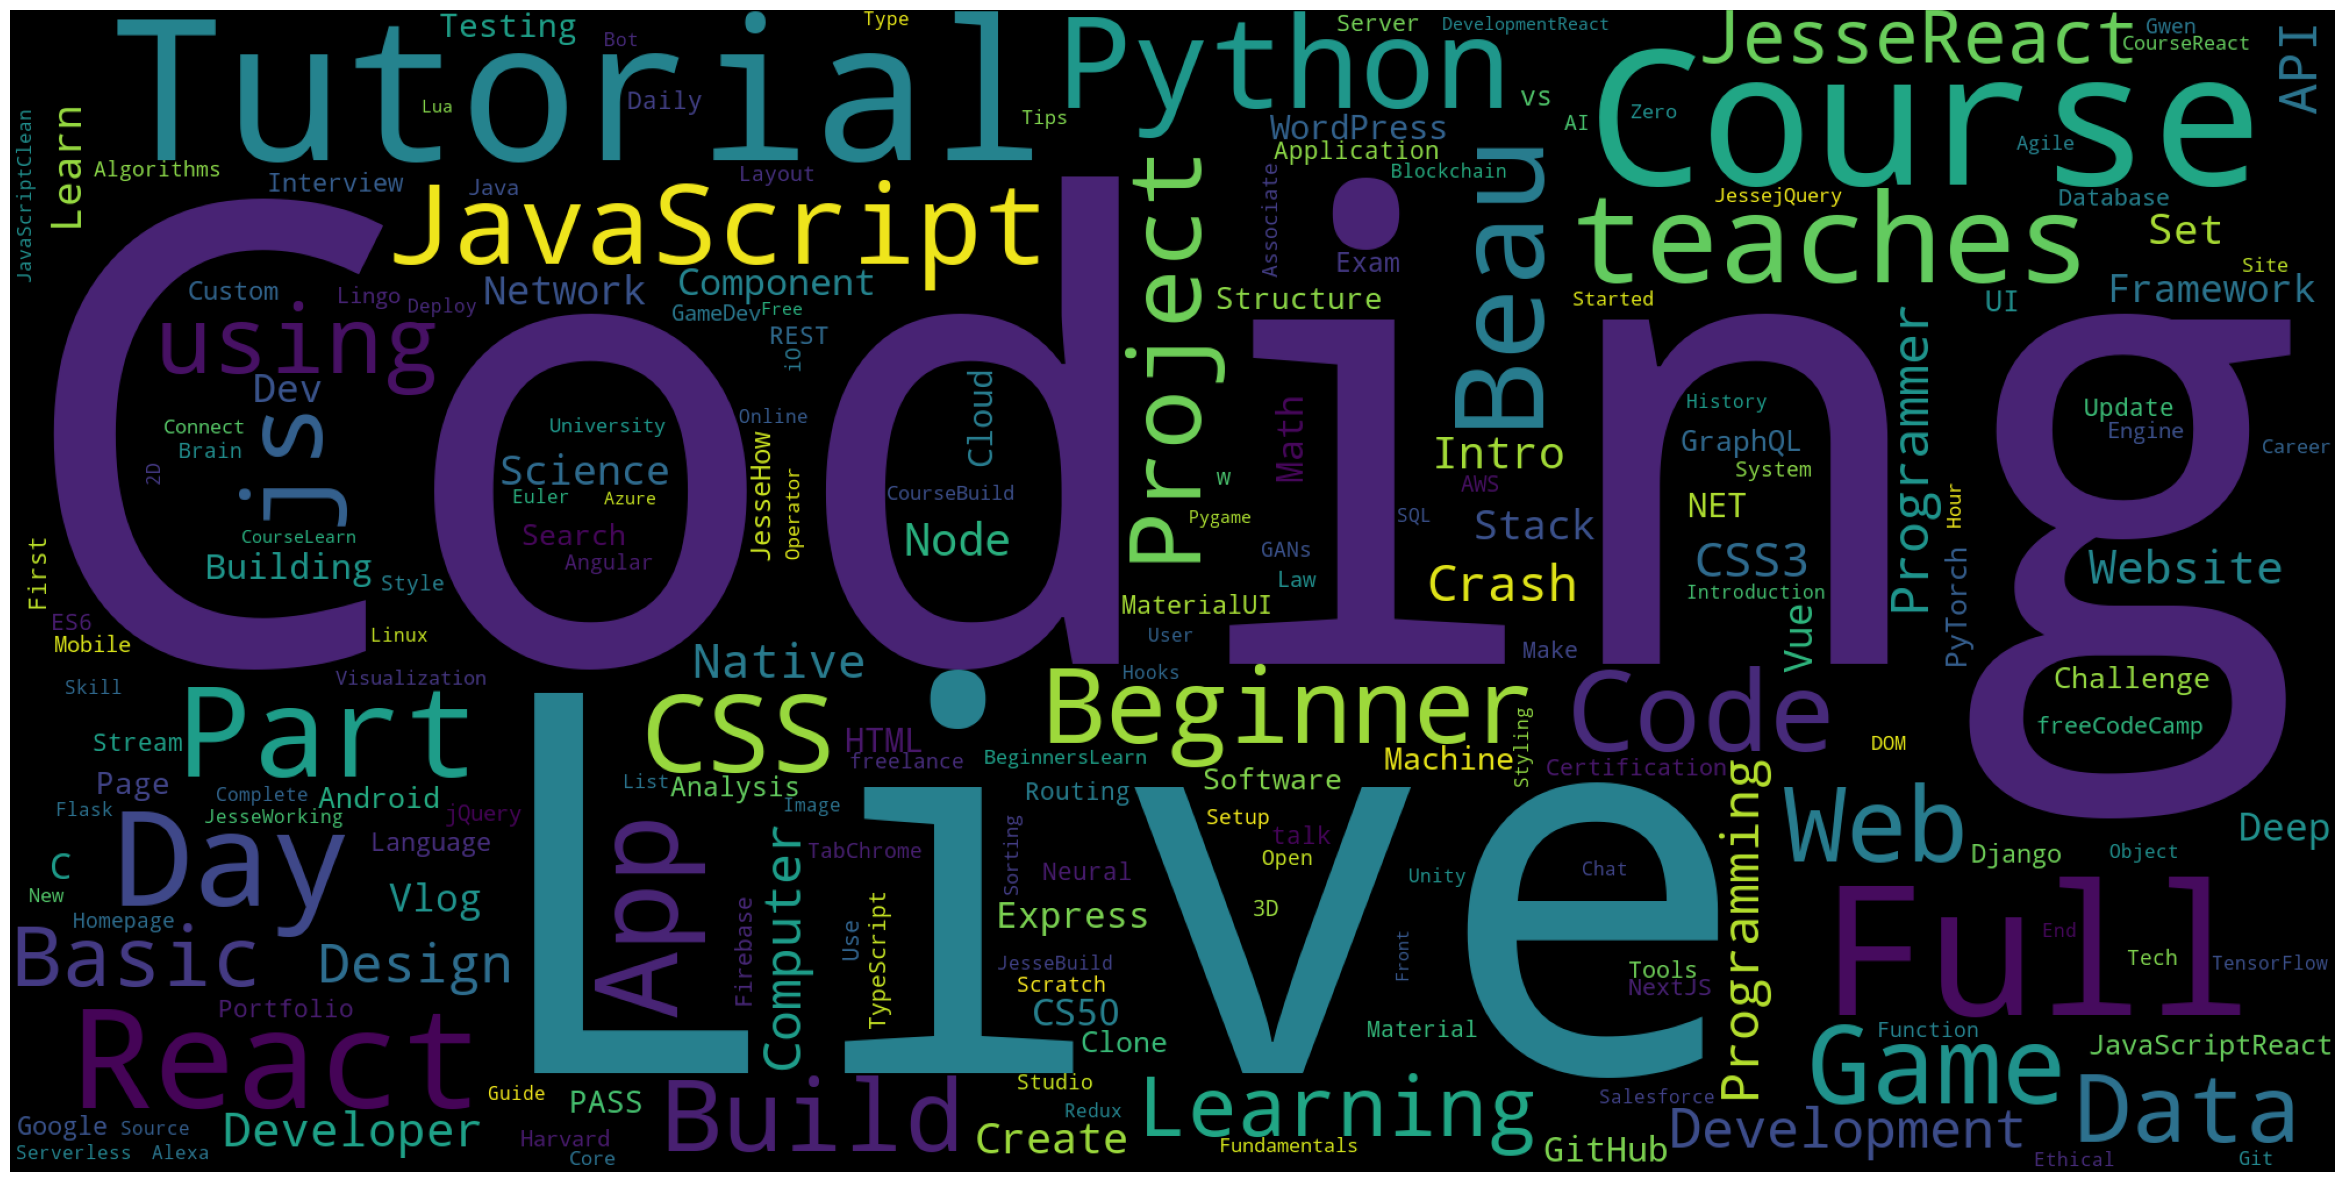

In [15]:
#word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = list([a for b in video_df['title'].to_list() for a in b])
all_words_str = ''.join(all_words)

def cloud(wordcloud):
    plt.figure(figsize=(30,20))
    plt.imshow(wordcloud)
    plt.axis("off")

wordcloud = WordCloud(width=2000, height=1000, random_state=1, background_color='black',collocations=False).generate(all_words_str)


cloud(wordcloud)

In [78]:
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x:parser.parse(x))
video_df['publishedDayName'] = video_df['publishedAt'].apply(lambda x:x.strftime("%A"))

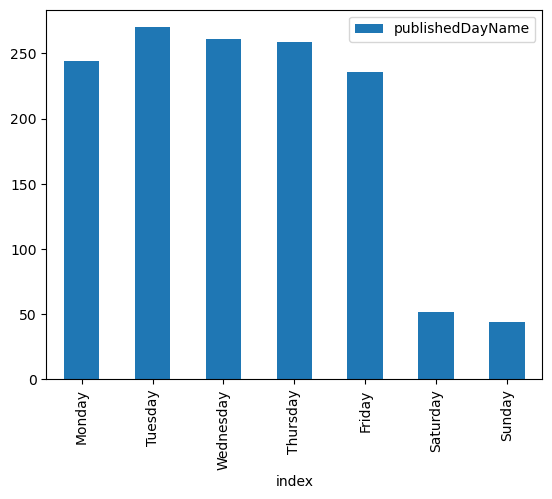

In [83]:
#days of the week upload the videos
#extract day in week

day = pd.DataFrame(video_df['publishedDayName'].value_counts())
weekdays =['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day = day.reindex(weekdays)
ax = day.reset_index().plot.bar(x='index',y='publishedDayName',rot=90)

In [18]:
from pathlib import Path
import pickle
root = Path(".")
my_path = root/'pickle files'
with open(my_path/'wordcloud.pkl','wb') as f:
        pickle.dump(all_words_str,f)

In [97]:
#new pickles

with open(my_path/'cert10.pkl','wb') as f:
        pickle.dump(c,f)

with open(my_path/'wordcloud.pkl','wb') as f:
        pickle.dump(all_words_str,f)

with open(my_path/'day.pkl','wb') as f:
        pickle.dump(day,f)
with open(my_path/'liked10.pkl','wb') as f:
        pickle.dump(liked10,f)

In [62]:
#clean_title has a set of keywords extacted using the nltk package we can use that to find out the most uploaded videos by topic 
video_df['clean_title'].value_counts()
count = video_df['clean_title'].value_counts()

#based on the keywords extracted in clean_title, find video categories that have more than 1 video posted on the channel
count = count.loc[count > 1]

#plot pie chart
fig_pie = px.pie(count, values=count.values, names= count.index, title ='Technologies that have more than 1 video posted')
fig_pie.update_traces(hoverinfo='label+percent', textinfo='value')
fig_pie.show()

In [81]:
#adfyha

total = video_df.viewCount.sum()

In [82]:
diff = video_df.viewCount[1:].sum()

In [83]:
d = (video_df.viewCount.sum()) - (video_df.viewCount[1:].sum())

TypeError: unsupported operand type(s) for -: 'str' and 'str'

21237.0

In [63]:
#pickle required files as we only want to load on required files into the streamlit app
from pathlib import Path
import pickle

root = Path(".")
my_path = root/'pickle files'

with open(my_path/'top10.pkl','wb') as f:
    pickle.dump(top10,f)

with open(my_path/'countvideos.pkl','wb') as f:
    pickle.dump(count,f)



### Hybrid Recommnder (content based and like count) with Lemmatization and POS tagging of video description. (Troy)

In [90]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,clean_description,clean_title,url
0,f4idgaq2VqA,freeCodeCamp.org,Jenkins Tutorial – How to Deploy a Test Server...,Learn about Jenkins by building a CI/CD pipeli...,None,2022-09-16T13:56:37Z,7827.0,747.0,NaN,28.0,PT1H3M10S,hd,false,learn jenkins build pipeline web application j...,jenkins tutorial deploy test server docker lin...,https://www.youtube.com/watch?v=f4idgaq2VqA
1,a_iQb1lnAEQ,freeCodeCamp.org,Learn HTML & CSS – Full Course for Beginners,Learn HTML and CSS from scratch by building 6 ...,None,2022-09-14T15:04:16Z,61698.0,3868.0,NaN,166.0,PT5H21M44S,hd,false,learn html cs scratch build project solve codi...,learn html cs full course beginner,https://www.youtube.com/watch?v=a_iQb1lnAEQ
2,FzlpwoeSrE0,freeCodeCamp.org,NoSQL vs SQL – Which Type of Database Should Y...,"When should you use RDBMS, and when should you...",None,2022-09-13T15:55:14Z,48215.0,1665.0,NaN,86.0,PT1H25M42S,hd,false,use rdbms use nosql course describe difference...,nosql v sql type database use,https://www.youtube.com/watch?v=FzlpwoeSrE0
3,XBTJDpT2XaI,freeCodeCamp.org,React Coding Interview Prep – 30 Questions and...,Prepare for a React interview or improve your ...,None,2022-09-12T15:55:09Z,35849.0,1705.0,NaN,123.0,PT4H40M34S,hd,false,prepare react interview improve react skill le...,react cod interview prep question answer,https://www.youtube.com/watch?v=XBTJDpT2XaI
4,3qBXWUpoPHo,freeCodeCamp.org,Angular for Beginners Course [Full Front End T...,Learn Angular in this complete course for begi...,None,2022-09-07T13:15:25Z,88369.0,3212.0,NaN,362.0,PT17H33M53S,hd,false,learn angular complete course beginner first l...,angular beginner course full front end tutoria...,https://www.youtube.com/watch?v=3qBXWUpoPHo


In [85]:
#build content based recommender 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfv = TfidfVectorizer()

tfv_matrix = tfv.fit_transform(video_df['clean_description'])
similarity = cosine_similarity(tfv_matrix, tfv_matrix)

indices = pd.Series(video_df.index, index=video_df['title'])

In [87]:
def recommendation(title, similarity=similarity):
    index = indices[title]
    sim_scores = list(enumerate(similarity[index]))
    sim_scores = sorted(sim_scores, key=lambda x:x[1], reverse=True)
    sim_scores = sim_scores[0:6]
    vid_indices = [i[0] for i in sim_scores]
    df=video_df['title'].iloc[vid_indices]
    df=df.to_frame()
    df= pd.merge(df, video_df[['likeCount']], left_index=True, right_index=True) #include count of likes
    df = df.sort_values(by=['likeCount'], ascending=False)
    df['url']= video_df['url'].iloc[vid_indices]
    def make_clickable(output):
        return '<a target="_blank" href="{}">{}</a>'.format(output,output)
    df = df.style.format({'url':make_clickable}) #make url clickable
    return df

In [88]:
recommendation('Jenkins Tutorial – How to Deploy a Test Server with Docker + Linux (Full Course)')

,title,likeCount,url
79,Visual Studio Code Extensions to Improve Your Productivity,4673.000000,https://www.youtube.com/watch?v=g1vy03ZY5mM
68,Low-Code for Freelance Developers & Startups – Tutorial,4661.000000,https://www.youtube.com/watch?v=hDzgO2FB_ms
129,Can you code on a phone? Android Mobile Programing Tutorial,3856.000000,https://www.youtube.com/watch?v=VZ6LifcOXfM
101,Blockchain Development: Querying with Open APIs Course,3808.000000,https://www.youtube.com/watch?v=cQx6ig3mp1U
16,Jenkins Tutorial – How to Deploy a Test Server with Docker + Linux (Full Course),3200.000000,https://www.youtube.com/watch?v=f4idgaq2VqA
55,React Testing Course for Beginners – Code and Test 3 Apps,2379.000000,https://www.youtube.com/watch?v=8vfQ6SWBZ-U


In [89]:
#pickle required files 
videos = video_df['title']

import pickle
with open(my_path/'sim.pkl','wb') as f:
    pickle.dump(similarity,f)

with open(my_path/'indices.pkl','wb') as f:
    pickle.dump(indices,f)

with open(my_path/'videos.pkl','wb') as f:
    pickle.dump(videos,f)

with open(my_path/'video_df.pkl','wb') as f:
    pickle.dump(video_df,f)

In [95]:
videos.values

array(['Jenkins Tutorial – How to Deploy a Test Server with Docker + Linux (Full Course)',
       'Learn HTML & CSS – Full Course for Beginners',
       'NoSQL vs SQL – Which Type of Database Should You Use?', ...,
       'Computer Basics 3: Intro to Binary Code',
       'Computer Basics 2: More Computer Hardware',
       'Computer Basics 1: The 4 Basic Parts of a Computer'], dtype=object)

## Content based Filter using video titles without lemmatization and POS tagging (Sparta)

In [90]:
#build content based recommender 

tfv2 = TfidfVectorizer(min_df=2, max_features=None,strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3),stop_words='english')

tfv2_matrix = tfv.fit_transform(video_df['title'])
similarity2 = cosine_similarity(tfv2_matrix, tfv2_matrix)

indices2 = pd.Series(video_df.index, index=video_df['title']).drop_duplicates()

In [91]:
def recommendation2(title, similarity=similarity2):
    index = indices2[title]
    sim_scores = list(enumerate(similarity[index]))
    sim_scores = sorted(sim_scores, key=lambda x:x[1], reverse=True)
    sim_scores = sim_scores[0:6]
    vid_indices = [i[0] for i in sim_scores]
    df=video_df['title'].iloc[vid_indices]
    df=df.to_frame()
    df['url']= video_df['url'].iloc[vid_indices]
    def make_clickable(output):
        return '<a target="_blank" href="{}">{}</a>'.format(output,output)
    df = df.style.format({'url':make_clickable}) #make url clickable
    return df

In [92]:
recommendation2('React JavaScript Framework for Beginners – Project-Based Course')

,title,url
21,React JavaScript Framework for Beginners – Project-Based Course,https://www.youtube.com/watch?v=u6gSSpfsoOQ
585,Python Django Web Framework - Full Course for Beginners,https://www.youtube.com/watch?v=F5mRW0jo-U4
130,Bootstrap CSS Framework - Full Course for Beginners,https://www.youtube.com/watch?v=-qfEOE4vtxE
597,Learn JavaScript - Full Course for Beginners,https://www.youtube.com/watch?v=PkZNo7MFNFg
153,Angular Tutorial for Beginners - Web Framework with Typescript Course,https://www.youtube.com/watch?v=AAu8bjj6-UI
34,JavaScript Game Development Course for Beginners,https://www.youtube.com/watch?v=GFO_txvwK_c


In [93]:
#pickle required files 
import pickle
with open(my_path/'sim2.pkl','wb') as f:
    pickle.dump(similarity2,f)

with open(my_path/'indices2.pkl','wb') as f:
    pickle.dump(indices2,f)

In [100]:
#clean_title has a set of keywords extacted using the nltk package we can use that to find out the most uploaded videos by topic 
video_df['clean_title'].value_counts()

react project day live coding jesse                             24
project euler challenge coding challenge florin                  6
build brain computer app react native part live coding jesse     6
amazon alexa skill development live stream day                   5
edit salesforce visualforce page part live coding jesse          3
                                                                ..
tensorflow crash course                                          1
react apis full tutorial hacker news api application             1
netlify tutorial build deploy website use netlify                1
build dapps ethereum blockchain beginner tutorial                1
computer basic basic part computer                               1
Name: clean_title, Length: 1291, dtype: int64

In [101]:
count = video_df[video_df['clean_title'].map(video_df['clean_title'].value_counts()) >=2]

In [102]:
count = video_df['clean_title'].value_counts()

In [103]:
count = count.loc[count > 1]

In [104]:
count = pd.DataFrame(count)

In [105]:
#most liked videos top 20
#most commented videos top 20 
#find the most publisked videos by day
#show statistics of similar videos by selection i.e like count, views, comments with a selectbox (hyperlink it inside .py file)


In [106]:
import plotly.express as px

fig_pie = px.pie(count, values=count.values, names= count.index, title ='Technologies that haave more than 1 video psoted')
fig_pie.update_traces(hoverinfo='label+percent', textinfo='value')
fig_pie.show()

ValueError: Data must be 1-dimensional